In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
%matplotlib inline


In [3]:
def Open_File(file_name):
    '''Function takes one input argument, a JSON-file,corresponding to the saved file-name,for each park, 
    from the result of the request to Twitters API and converts the JSON-file to a dictionary.   
    IN: file_name(JSON-object).
    OUT: Tweet_Data (Dictionary), Dictionary of the JSON-file.'''
    
    with open(file_name) as file:
        Tweet_Data= json.load(file)

    return Tweet_Data

In [4]:
def ToDataframe_text(Tweet_Data):
    '''  Function takes a dictionary corresponding to the JSON-file for each park, Extracts the "Text" data and returns
    a Pandas DataFrame with one column,Tweet/Text-data, were each row represents one unique Tweet.
    IN: Tweet_Data(Dictionary).
    OUT: DataFrame, with one column, Tweet/text-data.'''
    
    Df_list=[]
    for item in Tweet_Data['statuses']:
        if item['truncated']==True:
            Df_list.append(item['extended_tweet']['full_text'])
        else:
            Df_list.append(item['text'])
    pd.set_option('display.max_colwidth',-1)
    Df= pd.DataFrame(data=Df_list,columns=['Tweet'])
    return Df

'uncomment below rows for quick visualization'

#Tweet_Data=Open_File('TwitterData_Json'+'/Hagaparken_Tweet15-19.json')
#df_text= ToDataframe_text(Tweet_Data)

'uncomment below rows for quick visualization'

In [5]:
#importing pythons regular expression library.
import re
def clean_text_round1(text):
    ''' Funtion takes one input argument,the tweet column in our Dataframe,and removes URL-references and special characters
    that doesnt influence the sentiment such att #,numbers and /(see below) using pythons regular expression library. 
    Function returns a cleaned DataFramed. 
    IN: DataFranme, Tweet(text)-data column.
    OUT: DataFrame, cleaned from URL-references and special characters.'''
    
    text=re.sub(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)','',text)
    text=re.sub(r'@\S+ ', r'', text)
    text= re.sub(r'[@0-9.#/"?;():-]', '', text)
    return text


'uncomment below rows for quick visualization'
#round1=lambda tweet:clean_text_round1(tweet)
#df = pd.DataFrame(df_text['Tweet'].apply(round1))
#df.head(20)

'uncomment below rows for quick visualization'

In [6]:
import re

from nltk.corpus import stopwords
def clean_emoji(tweet):
    '''Funtion takes one input argument,the Tweet/Text column in our Dataframe,removes all characters that isnt a alphabetic
    letter using pythons regular expression library and returns a cleaned Tweet/Text column.
    IN: DataFrame column,Tweet-data.
    OUT: DataFrame, where Tweet/Text column only contains alphabetic letters.'''
    
    tweet=tweet.lower()
    tweet= re.sub(r'[^a-ö \s]','',tweet)
    tweet= re.sub(r'[\n]',' ',tweet)
     
    return tweet

In [7]:
# First filtering
from functools import reduce

def remove(tweet):
    ''' Funtion takes one input argument,the Tweet/Text-column in our Dataframe, and removes words That appear in 99% or more
    of all tweets.
    IN:DataFrame column, Tweet-data.
    OUT: DataFrame column, cleaned from commonly occured words.'''
    
    patternsToRemove = [
        r'[Ss]kogskyrkogård(en)?',
        r'[Pp]hoto',
        r'[Ss]venska?',
        r'[Mm]inneslunden',
        r'[Uu]nesco',
        r'[Ii]nstagram',
        r'[Ss]tockholm',
        r'[Jj]kpg',
        r'[Dd]ag(en)?',
        r'[Aa]lmhöjd',
        'r[Kk]ungälv'
    ]
    
    return reduce(lambda tweet, pattern: re.sub(pattern, '', tweet), patternsToRemove, tweet)
    
'uncomment below rows for quick visualization'   
#data_clean['Tweet']=data_clean['Tweet'].apply(lambda tweet: remove(tweet))
#data_clean.head(10)

'uncomment below rows for quick visualization'

In [8]:
from nltk import word_tokenize, pos_tag
def nouns(text):
    '''Given a string of text, tokenize it and pull out only the words'''
    is_noun_adj_vb= lambda pos: pos[:2] == 'NN' or pos[:2] =='VB' or pos[:2] =='JJ'
    tokenized = word_tokenize(text)
    all_nouns_adj_vb= [word for (word,pos) in pos_tag(tokenized) if is_noun_adj_vb(pos)]
    return ' '.join(all_nouns_adj_vb)

In [9]:

# filtering more words
filter_list=['in','af','at','by','jönköping','arse','enskede','utc','the','ock','nynäsvägen','idag','plats','bara','väg','rv','ska','all'
            'kungälv','falkenberg','sweden','amp','to','nya','dagens','almhöjd','am','kommer','dag','år','of','höjd',
            'får','ta','fint','också','foto','ligger','precis','många','va','bakom','posted','finns',
            'ttot','län','bra','sthlm','två','ner','går','mer','runt','bland','småland','götaland','heritage','cemetery',
            'kungsbacka','tranås','kvarter','tubbaryd','vissa','väl','vänster','vacker','day','eksjö','woodlandcemetery','forestcemetery']


def filter(tweet):
    tweet=tweet.lower()
    tweet_split= tweet.split(' ')
    
    for word in filter_list:
        if word in tweet_split:
            tweet_split.remove(word)

    
    if ' '.join(tweet_split):
        return ' '.join(tweet_split)
    
    else:
        return 'tom'

    
# data_clean['Tweet']= data_clean['Tweet'].apply(lambda tweet: filter(tweet))    

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from gensim import matutils, models
import scipy.sparse
import logging

''' The function below runs all the previous steps and returns the variables "id2word","coprus" which are going to be 
input variables in the lda-model in next cell. The function also returns the variable "df_dtm" which represents the cleaned
dataframe.'''

def data_toDTM():

    # Reading Tweet-data
    Tweet_Data = Open_File('../TwitterData_Json/Skogskyrkogården_Tweet15-19.json')
    df_text = ToDataframe_text(Tweet_Data)
    
    # cleaning round 1
    round1 = lambda tweet:clean_text_round1(tweet)
    df = pd.DataFrame(df_text['Tweet'].apply(round1))

    # removing all characters that isnt a alphabetic letter.
    df['Tweet'] = df['Tweet'].apply(lambda tweet: clean_emoji(tweet))

    # Removing stopwords from Tweet-data column using pythons nltk library.
    stop = stopwords.words('swedish')
    data_clean = pd.DataFrame(df['Tweet'].apply(lambda tweet: ' '.join([word for word in tweet.split(' ') if word not in (stop) ])))
    
    # Only nouns,adjectives and verbs includes in the analysis.
    data_clean = pd.DataFrame(data_clean['Tweet'].apply(nouns))
    
    # Removing common expressed words.
    data_clean['Tweet'] = data_clean['Tweet'].apply(lambda tweet: remove(tweet))
    data_clean['Tweet'] = data_clean['Tweet'].apply(lambda tweet: filter(tweet))
 
    # Delete these row indexes from dataFrame
    del_rows= data_clean[data_clean['Tweet']=='tom'].index
    data_clean.drop(del_rows , inplace=True)
    
    
    # In order to Implement the LDA-algoritm we Transform the DataFrame column Tweet-data to a Document Term Matrix
    # excludes words that appear in more then 90% and less then 0,25% of all tweets.
    cv = CountVectorizer(max_df=0.9,min_df=1)  
    data_cv = cv.fit_transform(data_clean['Tweet'])
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = data_clean.index

    # pickle the data
    pickle.dump(cv,open('cv.pkl_sk','wb'))

    #Required input for topic modeling is a term-document matrix
    #Which is the transpose of a DTM
    # columns=Tweets, rows= word 
    tdm=data_dtm.transpose()
    
    # putting the term-document matrix into a new gensim format, sparse matrix for efficency.
    sparse_counts = scipy.sparse.csr_matrix(tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)

    # Gensim also requires dictionary of all the terms and their respective location in the tdm
    cv = pickle.load(open('cv.pkl_sk','rb'))
    id2word = dict((v,k) for k, v in cv.vocabulary_.items())
    
    return id2word, corpus, data_clean





# Attempt 2 Nouns Adjective and Verbs

In [13]:
'Output from the function each lda-model takes the variables "id2word" and "corpus" as input.'
id2word,corpus,df_dtm = data_toDTM()

# 3 topics
lda= models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3,passes=20)
lda.print_topics()


C:\Users\theod\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


[(0,
  '0.024*"kungälv" + 0.010*"letsguide" + 0.008*"nature" + 0.007*"skogskyrkogardar" + 0.006*"griftegården" + 0.005*"vackert" + 0.004*"greta" + 0.004*"eksjö" + 0.004*"stora" + 0.004*"grav"'),
 (1,
  '0.006*"ljus" + 0.005*"död" + 0.003*"världsarv" + 0.003*"mamma" + 0.003*"sen" + 0.003*"polisen" + 0.003*"helt" + 0.003*"aug" + 0.003*"allhelgona" + 0.003*"fick"'),
 (2,
  '0.008*"gunnar" + 0.008*"woodland" + 0.006*"asplund" + 0.005*"trafikolycka" + 0.005*"världsarv" + 0.004*"lewerentz" + 0.004*"skogskapellet" + 0.003*"chapel" + 0.003*"world" + 0.003*"jul"')]

## Topics
### topic 1: Death, greta garbo, family(mother, father)
### topic 2: Nature, cemetery "världsarv
### topic 3: Architecture, gunnar asplund , Sigurd Lewerentz

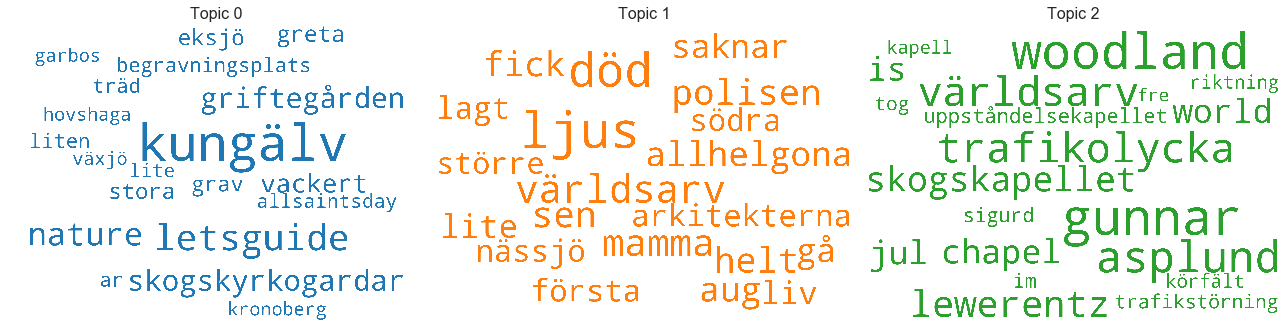

In [14]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.colors as mcolors

stop_words= stopwords.words('swedish')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(num_words=20,formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#fig.savefig('Skogskyrkogården_wordcloud.pdf')

In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df_dtm['Tweet']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=df_dtm['Tweet'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9541,"ljus, död, världsarv, mamma, sen, polisen, helt, aug, allhelgona, fick",börjat leta lägenhet hemnet vafan hålla reda pengar skit fy fan slår tält ger
1,1,1.0,0.7665,"ljus, död, världsarv, mamma, sen, polisen, helt, aug, allhelgona, fick",lyste hela
2,2,2.0,0.7191,"gunnar, woodland, asplund, trafikolycka, världsarv, lewerentz, skogskapellet, chapel, world, jul",minnas svärfar jessicas pappa bo stjärnfeldt gått mången tår fått tomhet lämnade smärta alltid hjärta
3,3,2.0,0.9623,"gunnar, woodland, asplund, trafikolycka, världsarv, lewerentz, skogskapellet, chapel, world, jul",tv öppna com hem telia bredbandsbol o canal digital sappa konstnären roland kempe världsarv svpt svpol samtidigt internet
4,4,2.0,0.9132,"gunnar, woodland, asplund, trafikolycka, världsarv, lewerentz, skogskapellet, chapel, world, jul",sdatum invigdes uppståndelsekapellet s världsarv byggdes större kapell läs
5,5,1.0,0.7854,"ljus, död, världsarv, mamma, sen, polisen, helt, aug, allhelgona, fick",tro mörknar färden solen slocknat blott timmar strålar julsmorgon klar letsguide nature
6,6,0.0,0.9657,"kungälv, letsguide, nature, skogskyrkogardar, griftegården, vackert, greta, eksjö, stora, grav",rackarn blåste nerför rävåskullen cykel gångstigen rävåskyrkan meter framför rakt ur skogen typ piketpolis saktade direkt drog film galet
7,7,0.0,0.8244,"kungälv, letsguide, nature, skogskyrkogardar, griftegården, vackert, greta, eksjö, stora, grav",way grandfather funeral
8,8,2.0,0.9349,"gunnar, woodland, asplund, trafikolycka, världsarv, lewerentz, skogskapellet, chapel, world, jul",sandsborgs kyrkogård resoektive vidare framåt länkar hakar varann livet döden deckarlogg sandsborgskyrkogård
9,9,2.0,0.9623,"gunnar, woodland, asplund, trafikolycka, världsarv, lewerentz, skogskapellet, chapel, world, jul",tv öppna com hem telia bredbandsbol o canal digital sappa konstnären roland kempe världsarv svpt svpol samtidigt internet


In [16]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Text(0.5, 1.0, 'Number of Tweets by Dominant Topic')

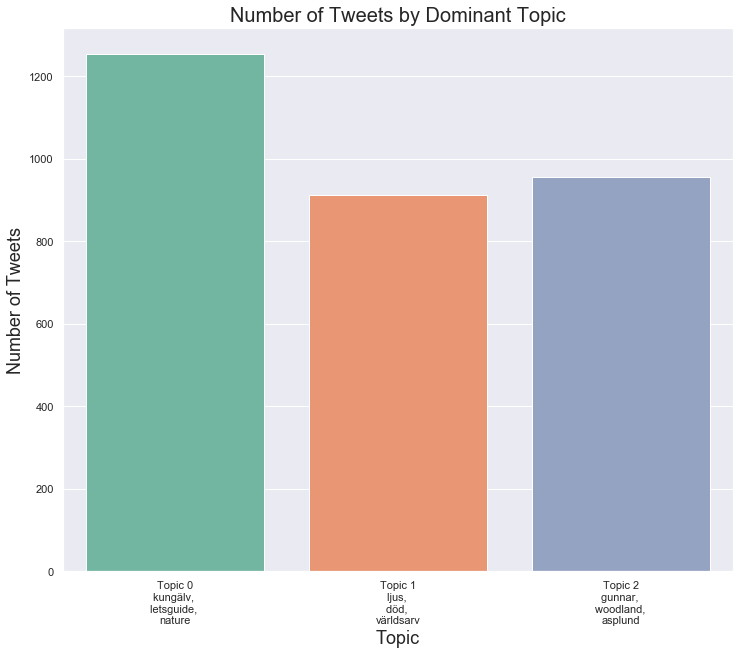

In [17]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette('dark')
fig,ax_count= plt.subplots(figsize=(12,10))

#Countplot All Sentiment
ax_count=sns.countplot(x='Dominant_Topic',data=df_dominant_topic,palette='Set2')
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax_count.xaxis.set_major_formatter(tick_formatter)

ax_count.set_xlabel('Topic',fontsize=18) 
ax_count.set_ylabel('Number of Tweets',fontsize=18)
ax_count.set_title('Number of Tweets by Dominant Topic',fontsize=20)

#fig.savefig('Skogskyrkogården_Dominanttopic.pdf')
